# Response Times and Traceroutes

In [174]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from analysis_util.constants import PROTOCOLS, IP_VERSIONS, CONTINENTS, CONTINENT_NAMES, CONTINENT_DISPLAY_ORDER
from analysis_util.constants import RESOLVER_NAMES, RESOLVER_ADDRESSES, RESOLVER_DISPLAY_ORDER, AS_NAMES
from analysis_util.db_util import DatabaseReader 
from analysis_util.df_manipulation import create_resolver_column, create_continent_name_column
from analysis_util.df_manipulation import create_traceroute_resolver_column, create_table_column
from analysis_util.file_util import PlotSaver
from analysis_util.plot_util import get_plot_index, plot_heatmap
import math
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [175]:
RESOLVER_DISPLAY_ORDER = ['Public Resolver',
 'CleanBrowsing',
 'Cloudflare',
 'Comodo',
 'Google',
 'Neustar',
 'OpenDNS',
 'OpenNIC',
 'Quad9',
 'UncensoredDNS',
 'Yandex',
 'Probe Resolver']

## DB-connection

In [176]:
db_rq1 = DatabaseReader('data/ripe_results.db')
db_rq2 = DatabaseReader('data/ripe_results_txt.db')

saver_rq1 = PlotSaver("plots/rq1/")
saver_rq2 = PlotSaver("plots/rq2/")
savers = [saver_rq1, saver_rq2]

# Runtime 

In [177]:
def get_and_prepare_runtime_data(db_reader):
    tcp_v4_runtimes = db_reader.select_runtime_data(4, 'TCP')
    udp_v4_runtimes = db_reader.select_runtime_data(4, 'UDP')
    tcp_v6_runtimes = db_reader.select_runtime_data(6, 'TCP')
    udp_v6_runtimes = db_reader.select_runtime_data(6, 'UDP')
    
    data = [
       ('DoTCP IPv4', tcp_v4_runtimes),
       ('DoUDP IPv4', udp_v4_runtimes),
       ('DoTCP IPv6', tcp_v6_runtimes),
       ('DoUDP IPv6', udp_v6_runtimes)
    ]
    
    runtime_data = []
    runtime_data_public_vs_probe = []
    for key, df in data: 
        print(f"Done loading {key}. Preparing data...")
        df['resolver'] = df.apply(create_resolver_column, axis=1)
        print("Done 1")
        df['continent'] = df.apply(create_continent_name_column, axis = 1)
        df = df.replace({'as_name': AS_NAMES})
        runtime_data.append((key,df))
        print("Done 2")        
        df_pub = df[df['resolver'] != 'Probe Resolver']

        df_prb = df[df['resolver'] == 'Probe Resolver']
        runtime_data_public_vs_probe.append((f"{key} Public Resolvers", df_pub))
        runtime_data_public_vs_probe.append((f"{key} Probe Resolvers", df_prb))
    
    top_ases = db_reader.get_top_ases()
    print("Done 3")        
    return runtime_data, runtime_data_public_vs_probe, top_ases

In [178]:
runtime_data_rq1, runtime_data_prb_pub_rq1, top_ases_rq1 = get_and_prepare_runtime_data(db_rq1)
print("test0")
#runtime_data_rq2, runtime_data_prb_pub_rq2, top_ases_rq2 = get_and_prepare_runtime_data(db_rq2)
print("test")

Done loading DoTCP IPv4. Preparing data...
Done 1
Done 2
Done loading DoUDP IPv4. Preparing data...
Done 1
Done 2
Done loading DoTCP IPv6. Preparing data...
Done 1
Done 2
Done loading DoUDP IPv6. Preparing data...
Done 1
Done 2
Done 3
test0
test


In [179]:
runtime_data_rq1

[('DoTCP IPv4',
                rt use_probe_resolver  prb_id continent_code         dst_addr  \
  0         25.949               None   52824             EU          1.1.1.1   
  1         45.611               None   52827             EU          1.1.1.1   
  2         58.797               None   52828             NA          1.1.1.1   
  3         45.520               None   52844             AS          1.1.1.1   
  4         24.815               None   52849             NA          1.1.1.1   
  ...          ...                ...     ...            ...              ...   
  1590152   43.447               True   51924             AS          8.8.8.8   
  1590153    3.408               True   53961             EU    109.194.112.1   
  1590154  113.673               True   54550             EU          8.8.8.8   
  1590155   90.623               True   54778             AS         9.9.9.11   
  1590156    5.855               True   54983             AS  114.114.114.114   
  
         

## Boxplots

In [180]:
for saver in savers:
    saver.current_path = 'dns_runtimes/boxplots/'

In [181]:
def plot_general_runtime_boxplots(runtime_data_prb_pub, plot_saver):
    plots_pub = []
    labels_pub = []
    
    plots_prb = []
    labels_prb = []
    
    for key, df in runtime_data_prb_pub:
        df = df.groupby(['prb_id'], as_index=False)['rt'].median()
        runtimes = df['rt'].to_numpy()
        if "Public" in key:
            plots_pub.append(runtimes)
            labels_pub.append(key[:10])
        else:
            plots_prb.append(runtimes)
            labels_prb.append(key[:10])
    
    fig, ax_pub =  plt.subplots()
    fig.set_figwidth(10)
    ax_pub.set_xticklabels(labels_pub)
    ax_pub.boxplot(plots_pub)    
    ax_pub.set_title("Public Resolvers")
    
    fig, ax_prb =  plt.subplots()
    fig.set_figwidth(10)
    ax_prb.set_xticklabels(labels_prb)
    ax_prb.boxplot(plots_prb)
    ax_prb.set_title("Probe Resolvers")

    plot_saver.save_figure(fig, "overall_probe_resolvers_runtimes.pdf")

### RQ 1 - google.com

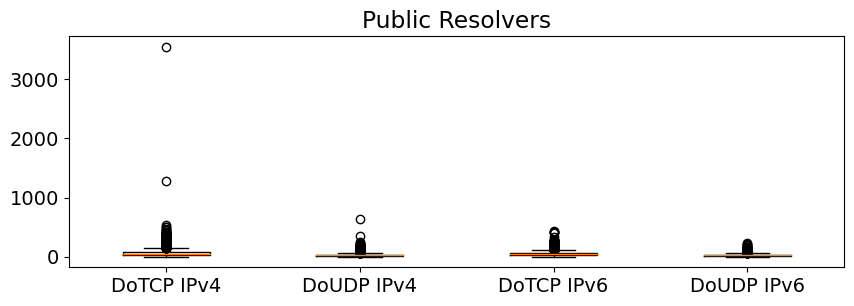

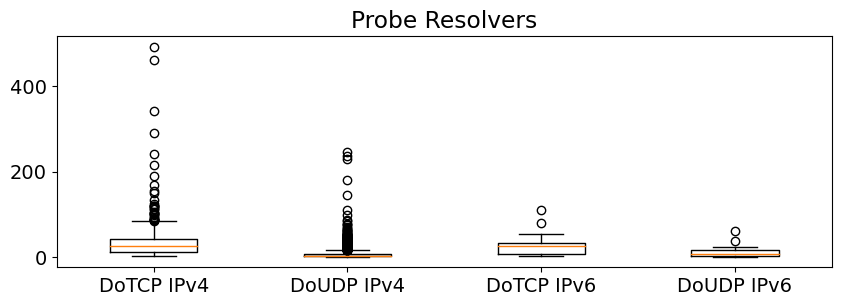

In [182]:
plot_general_runtime_boxplots(runtime_data_prb_pub_rq1, saver_rq1)

### RQ2 - membrain-it.technology

In [183]:
plot_general_runtime_boxplots(runtime_data_prb_pub_rq2, saver_rq2)

NameError: name 'runtime_data_prb_pub_rq2' is not defined

In [ ]:
def plot_runtime_boxplots_version_proto(runtime_data, saver):
    use_probe_options = [True, False]
    for key, df in runtime_data:
        plots = []
        labels = []
        for use_probe in use_probe_options:     
            group = df[df['resolver'] == 'Probe Resolver' if use_probe else df['resolver'] != 'Probe Resolver']
            group = group.groupby(['prb_id'], as_index=False)['rt'].median()
            runtimes = group['rt'].to_numpy()
            plots.append(runtimes)
            labels.append('Probe Resolver' if use_probe else 'Public Resolver')
            
        fig, ax =  plt.subplots()
        fig.set_figwidth(5)
        fig.set_figheight(4)
        ax.boxplot(plots)
        ax.set_xticklabels(labels)
        ax.set_title(key)
        saver.save_figure(fig,f"{key.lower()}_public_vs_probe.pdf")

### RQ1 - google.com 

In [ ]:
plot_runtime_boxplots_version_proto(runtime_data_rq1, saver_rq1)

### RQ 2 - membrain-it.technology

In [ ]:
plot_runtime_boxplots_version_proto(runtime_data_rq2, saver_rq2)

In [ ]:
def plot_runtimes_per_continent(runtime_data, saver):
    for key, df in runtime_data:
        plots = []
        labels = []
        groups = df.groupby(by=['continent_code'])
        use_probe_options = [True, False]
        for (continent, group) in groups: 
            for use_probe in use_probe_options:
                g = group[group['resolver'] == 'Probe Resolver'] if use_probe else group[group['resolver'] != 'Probe Resolver']
                g = g.groupby(['prb_id'], as_index=False)['rt'].median()
                runtimes = g['rt'].to_numpy()
                plots.append(runtimes)
                labels.append(f'Probe,{continent}' if use_probe else f'Public,{continent}')

        for i in range(len(plots))[::2]:
            fig, ax = plt.subplots()
            fig.set_figwidth(5)
            fig.set_figheight(4)
            ax.set_title(f'{key}, {labels[i][-2::]}')
            ax.set_xticklabels(labels[i:i+2], rotation='vertical')
            ax.boxplot(plots[i:i+2])
            saver.save_figure(fig, f"{labels[i][-2::]}_{key}_public_vs_probe.pdf")
        
        fig, ax = plt.subplots()
        fig.set_figwidth(5)
        fig.set_figheight(4)
        ax.set_title(key)
        ax.set_xticklabels(labels, rotation='vertical')
        ax.boxplot(plots)
        saver.save_figure(fig, f"per_continent_{key}_public_vs_probe.pdf")
        

### RQ1 - google.com

In [ ]:
plot_runtimes_per_continent(runtime_data_rq1, saver_rq1)

### RQ2 - membrain-it.technology

In [ ]:
plot_runtimes_per_continent(runtime_data_rq2, saver_rq2)

### Per resolver

In [ ]:
def plot_runtimes_per_resolver(runtime_data, saver):
    for key, df in runtime_data:
        plots = []
        labels = []
        groups = df.groupby(by=['resolver'])
        for resolver, group in groups:
            runtimes = group.groupby(by=['prb_id'])['rt'].median()
            plots.append(runtimes)
            labels.append(f'{resolver}')
        fig, ax =  plt.subplots()
        fig.set_figwidth(5)
        fig.set_figheight(4)
        ax.set_title(key)
        ax.set_xticklabels(labels, rotation='vertical')
        ax.boxplot(plots)
        saver.save_figure(fig, f"per_resolver_{key.lower()}.pdf")

### RQ1 - google.com

In [ ]:
plot_runtimes_per_resolver(runtime_data_rq1, saver_rq1)

### RQ2 - membrain-it.technology

In [ ]:
plot_runtimes_per_resolver(runtime_data_rq2, saver_rq2)

## CDFs

### Per Resolver

In [ ]:
for saver in savers: 
    saver.current_path = 'dns_runtimes/cdfs/'

In [184]:
def plot_cdf_per_resolver(runtime_data, saver):
    N = 11
    cm = plt.get_cmap('tab20')
    plt.rcParams["figure.figsize"] = (7,3)
    plt.rcParams['font.size'] = 14
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20(np.linspace(0,1,N)))
    plt.set_cmap("tab20")
    

    
    for key, df in runtime_data:
        plots = []
        #fig, gx = plt.subplots()
        #plots.spines['right'].set_visible(False)
        #plots.spines['top'].set_visible(False)
        labels = []     
        xs = []
        ys = []
        markers = []
        
        groups = df.groupby(by=['resolver'])   
        for resolver, group in groups:
            
            if resolver == "Comodo":
                continue
            runtimes = group.groupby(by=['prb_id'])['rt'].median()
            
            plots.append(runtimes)
            
            
            labels.append(f'{resolver}')
            xs.append(np.sort(runtimes))
            ys.append(np.arange(len(runtimes)) / float(len(runtimes)))
            markers.append(f"{resolver}")
            
    
        if "IPv4" in key: 
            runtimes = df[df["resolver"] == "Comodo"].groupby(by=['prb_id'])['rt'].median()
            plots.append(runtimes)
            labels.append(f'Comodo')
            xs.append(np.sort(runtimes))
            ys.append(np.arange(len(runtimes)) / float(len(runtimes)))
            markers.append(f"Comodo")
            
            
    
        fig, ax = plt.subplots(1, 1)
        ax.set_xlabel('Response Time (ms)', fontsize=14)
        


    #    ax.set_title(key)
        if key == "DoUDP IPv6":
            xs.append([])
            ys.append([])
            markers.append("Comodo")
        for i in range(len(xs)): 
            ax.plot(xs[i], ys[i], label=markers[i])
            
        if "DoTCP" in key:
            ax.set_xbound(lower=0, upper=1300)
        if "DoUDP" in key:
            ax.set_xbound(lower=0, upper=500)
        if key == "DoUDP IPv6":
            ax.legend(ncol=2, prop={'size': 12})
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.05))
        ax.spines['left'].set_position(('axes', -0.05))
        saver.save_figure(plt, f"per_resolver_{key.lower().replace(' ', '_')}.pdf")
        #plt.savefig("per_resolver_{key.lower().replace(' ', '_')}.pdf")





### RQ1- google.com

<Figure size 700x300 with 0 Axes>

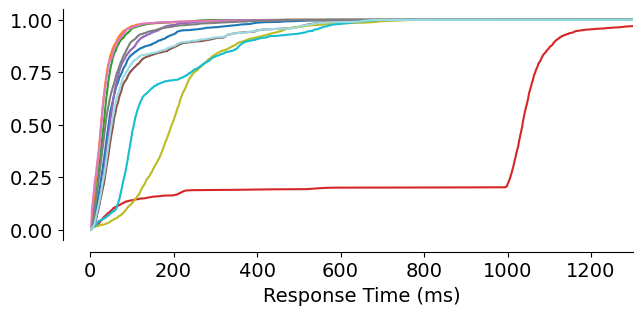

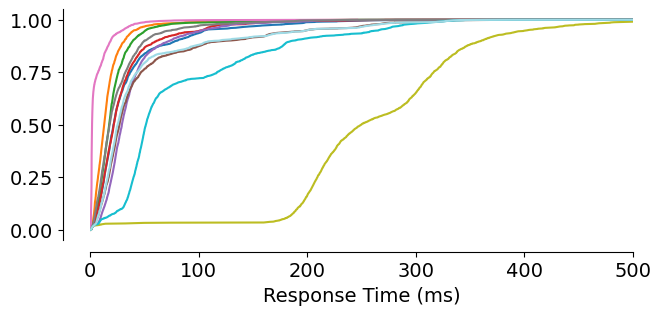

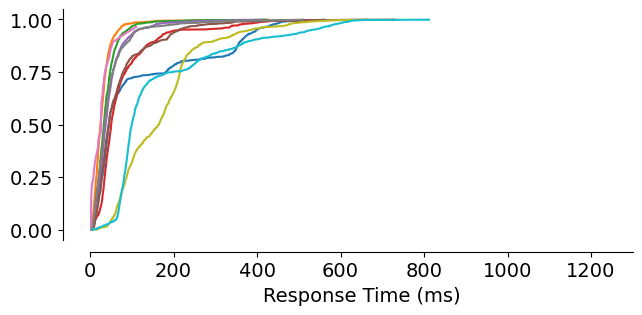

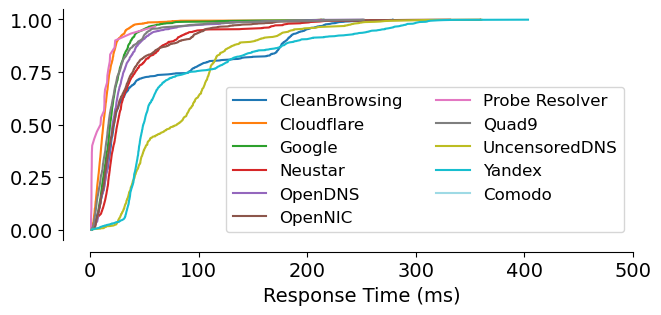

In [185]:
plot_cdf_per_resolver(runtime_data_rq1, saver_rq1)

### RQ2 - membrain-it.technology

In [ ]:
plot_cdf_per_resolver(runtime_data_rq2, saver_rq2)

### Per continent

In [ ]:
def plot_cdf_per_continent(runtime_data_prb_pub, saver):
    for key, df in runtime_data_prb_pub: 
        xs = []
        ys = []
        markers = []
        groups = df.groupby(by=['continent_code'])
        for continent, group in groups:
            runtimes = group.groupby(by=['prb_id'])['rt'].median()
            xs.append(np.sort(runtimes))
            ys.append(np.arange(len(runtimes)) / float(len(runtimes)))
            markers.append(f"{continent}")

        fig, ax = plt.subplots()
        fig.set_figwidth(5)
        fig.set_figheight(4)

        ax.set_xlabel('Runtime (ms)')
        ax.set_title(key)
        for i in range(len(xs)): 
            ax.plot(xs[i], ys[i], label=markers[i])
        ax.legend()
        saver.save_figure(fig, f"per_continent_{key}.pdf")


### RQ1 - google.com

In [ ]:
plot_cdf_per_continent(runtime_data_prb_pub_rq1, saver_rq1)

### RQ2 - membrain-it.technology

In [ ]:
plot_cdf_per_continent(runtime_data_prb_pub_rq2, saver_rq2)

## Response Times - Heatmap 

In [ ]:
for key, df in runtime_data_rq1:
    display(df)
    df = df.groupby(["prb_id", "msm_id", "sub_id"], as_index = False).size()


In [ ]:
for saver in savers: 
    saver.current_path = 'dns_runtimes/heatmaps/'

In [ ]:
def merge_rts(runtime_data):
    res = []
    for i in [0,2]:
        key_tcp, df_tcp = runtime_data[i]
        key_udp, df_udp = runtime_data[i + 1]
        
        
        rt_tcp = df_tcp.dropna(subset=["rt"])
        rt_udp = df_udp.dropna(subset=["rt"])
        
        rt_pr_udp = rt_udp.groupby(['prb_id', 'resolver', 'continent', 'asn', 'as_name'],
                           as_index=False)['rt'].median()
        
        rt_pr_tcp = rt_tcp.groupby(['prb_id', 'resolver', 'continent', 'asn', 'as_name'],
                           as_index=False)['rt'].median()
        
        # inner join will remove all probe resolvers that do not respond over DoTCP
        rt_merged = rt_pr_udp.merge(rt_pr_tcp, on=['prb_id', 'resolver', 'continent', 'asn', 'as_name'
                                          ], suffixes=['_udp', '_tcp'])
        
        res.append(("IPv4" if i == 0 else "IPv6", rt_merged)) 
    return res

In [ ]:
def plot_heatmap1(data, axs, plot_count, is_diff = False, is_asn = False, is_cont = False, is_failure_rate = False):
    ax = axs[get_plot_index(plot_count,3)]
    cmap = "RdYlGn_r" if not is_diff else 'RdBu_r'

    vmin = 0 if not is_diff else -200
    vmax = 500 if not is_diff else 200
    fmt='g'
    cbar_kws = {'label' : 'Response Time'}

    sns.heatmap(data,  
                fmt=fmt,  
                annot=True,
                cbar=is_asn,
                cmap=cmap,
                cbar_kws = cbar_kws,
                ax = ax,
                vmin=vmin,
                vmax=vmax)
    if not is_diff:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels([])
        if is_asn or is_cont:
            ax.set_yticklabels([])
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        if is_asn or is_cont:
            ax.set_yticklabels([])

In [ ]:
def get_median_runtimes_for_continent_and_resolver_protocol(df, proto):
    rt_name = "rt_" + proto
 
    public_resolver = df[df["resolver"] != "Probe Resolver"]
    public_resolver['resolver'] = 'Public Resolver'
    df = pd.concat([df, public_resolver], ignore_index=True)
    crosstab_continent = pd.crosstab(df['resolver'],
                    df['continent'],
                    values=df[rt_name], aggfunc='median').round(1)
    
    crosstab_continent = crosstab_continent[CONTINENT_DISPLAY_ORDER]
    crosstab_continent = crosstab_continent.reindex(RESOLVER_DISPLAY_ORDER)
    
    return crosstab_continent

def get_median_runtimes_for_continent_and_resolver(df):
#    df_continent = df.groupby(['prb_id', 'resolver', 'continent'], as_index=False)['rt'].median()
    return get_median_runtimes_for_continent_and_resolver_protocol(df, "tcp"), get_median_runtimes_for_continent_and_resolver_protocol(df, "udp")
    

In [ ]:
def get_median_runtimes_for_ases_protocol(df, ases, proto):
    rt_name = "rt_" + proto
    
    asns = [item[0] for item in ases]
    ases_names = [item[1] if item[1] not in list(AS_NAMES.keys()) else AS_NAMES[item[1]] for item in ases]
    df_ases = df[df['asn'].isin(asns)]
    #df_ases = df_ases.groupby(['prb_id', 'resolver', 'as_name'], as_index=False)['rt'].median()
    public_resolver = df_ases[df_ases["resolver"] != "Probe Resolver"]
    public_resolver['resolver'] = 'Public Resolver'
    df_ases = pd.concat([df_ases, public_resolver], ignore_index=True)

    
    crosstab_ases = pd.crosstab(df_ases['resolver'],
                    df_ases['as_name'],
                    values=df_ases[rt_name], aggfunc='median').round(1)
    crosstab_ases = crosstab_ases[ases_names]
    
    crosstab_ases = crosstab_ases.reindex(RESOLVER_DISPLAY_ORDER)

    return crosstab_ases

def get_median_runtimes_for_ases(df, ases):
    return get_median_runtimes_for_ases_protocol(df, ases, "tcp"), get_median_runtimes_for_ases_protocol(df, ases, "udp")

In [ ]:
def get_total_for_protocol(df, proto):
    rt_name = "rt_" + proto
    total_public = {}
    total_public["prb_id"] = 0
    total_public[rt_name] = df[df["resolver"] != "Probe Resolver"][rt_name].median()
    total_public["resolver"] = "Public Resolver"
    total_public = pd.DataFrame(total_public, index=[0])

    total = df.groupby(['resolver'], as_index = False)[rt_name].median()
    total = total.append(total_public, ignore_index = False)
    total = total.set_index('resolver')
    total = total[[rt_name]]
    total = total.rename(columns={rt_name: 'Total'})
    total = total.reindex(RESOLVER_DISPLAY_ORDER)
    return total.round(1)

def get_total(df):
    return get_total_for_protocol(df, "tcp"), get_total_for_protocol(df, "udp")

In [ ]:
def plot_runtime_heatmap(runtime_data, saver, ases):
    rt_merged_all = merge_rts(runtime_data)
    
    for key, rt_merged in rt_merged_all:
        plot_count = 0 
        fig, axs = plt.subplots(nrows=2, 
                                ncols=3, 
                                gridspec_kw = {'wspace':0.05,
                                            'hspace':0.15, 
                                          'width_ratios': [1, 5, 9]})
        fig.set_figheight(10)
        fig.set_figwidth(20)

        display(rt_merged[["rt_tcp", "rt_udp"]].corr())
        total_tcp, total_udp = get_total(rt_merged)
        
        medians_tcp_continent, medians_udp_continent = get_median_runtimes_for_continent_and_resolver(rt_merged)

        medians_tcp_ases, medians_udp_ases = get_median_runtimes_for_ases(rt_merged, ases)    

        plot_heatmap1(total_tcp, axs, plot_count)
        plot_count += 1

        plot_heatmap1(medians_tcp_continent, axs, plot_count, is_cont = True)
        plot_count += 1

        plot_heatmap1(medians_tcp_ases, axs, plot_count, is_asn=True)
        plot_count += 1

        plot_heatmap1(total_tcp - total_udp, axs, plot_count, is_diff=True)
        plot_count += 1

        plot_heatmap1(medians_tcp_continent - medians_udp_continent, axs, plot_count, is_diff = True,  is_cont = True)
        plot_count += 1

        plot_heatmap1(medians_tcp_ases - medians_udp_ases, axs, plot_count, is_diff = True, is_asn = True)
        plot_count += 1

        saver.save_figure(fig, f"{key}.pdf")

### RQ1 - google.com

In [ ]:
plot_runtime_heatmap(runtime_data_rq1, saver_rq1, top_ases_rq1)

### 

In [ ]:
plot_runtime_heatmap(runtime_data_rq2, saver_rq2, top_ases_rq2)

# Traceroute

In [ ]:
savers[0].current_path = 'traceroute/'

In [ ]:
def select_and_prepare_traceroute_data(db_reader):
    v4_data = db_reader.select_traceroute_data(4)
    v6_data = db_reader.select_traceroute_data(6)
    
    data = [
       ('IPv4', v4_data),
       ('IPv6', v6_data)
    ]
    
    traceroute_data = []
    traceroute_data_public_vs_probe = []
    for key, df in data:
        df['resolver'] = df.apply(create_traceroute_resolver_column, axis=1)
        df['continent'] = df.apply(create_continent_name_column, axis = 1)
        df = df.replace({'as_name': AS_NAMES})
        traceroute_data.append((key,df))
        
        df_pub = df[df['resolver'] != 'Probe Resolver']
        df_prb = df[df['resolver'] == 'Probe Resolver']
        traceroute_data_public_vs_probe.append((f"{key} Public Resolvers", df_pub))
        traceroute_data_public_vs_probe.append((f"{key} Probe Resolvers", df_prb))
    
    top_ases = db_reader.get_top_ases()
    return traceroute_data, traceroute_data_public_vs_probe, top_ases

In [ ]:
traceroute_data, traceroute_data_prb_pub, top_ases = select_and_prepare_traceroute_data(db_rq1)

In [ ]:
import sqlite3 
conn = sqlite3.connect("data/ripe_results.db")
res = pd.read_sql("SELECT * FROM hop_results", conn)

In [ ]:
df = res.groupby(["msm_id", "prb_id", "af"], as_index=False).size()
df[df["af"] == 4]
df[df["af"] == 6]

In [ ]:
df_v4 = traceroute_data[0][1]
df_v4[df_v4["resolver"] != "Probe Resolver"]

In [ ]:
df_v6 = traceroute_data[1][1]
df_v6[df_v6["resolver"] != "Probe Resolver"]

In [ ]:
for key, df in traceroute_data:
    top_resolvers = df[~df['dst_addr'].isin(RESOLVER_ADDRESSES)]
    top_resolvers = top_resolvers['dst_addr'].value_counts().to_frame('count')
    print(top_resolvers['count'].sum())
    display(top_resolvers)

## Distance 

In [ ]:

fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(16)
fig.set_figheight(8)
plot_count = 0
for key, df in traceroute_data: 
    xs = []
    ys = []
    markers = []
    groups = df.groupby("resolver")
    for (resolver, group) in groups:
        if resolver == "Comodo":
            continue
        hops = group['hops'].to_numpy()
        xs.append(np.sort(hops))
        ys.append(np.arange(len(hops)) / float(len(hops)))
        markers.append(f"{resolver}") 
    _, col = get_plot_index(plot_count)
    ax = axs[col]
    ax.set_title(key)
    for i in range(len(xs)): 
        ax.plot(xs[i], ys[i], label=markers[i])
    ax.legend()
    plot_count += 1
    


In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=8)
fig.set_figwidth(16)
fig.set_figheight(40)
plot_count = 0
for key, df in traceroute_data:
    xs = []
    ys = []
    markers = []
    groups = df.groupby("continent")
    for (continent, group) in groups:
        group = group.groupby(["continent", "prb_id", "resolver"], as_index=False)["hops"].median()
        df_prb = group[group['resolver'] == 'Probe Resolver']
        df_pub = group[group['resolver'] != 'Probe Resolver']

        hops_pub = df_pub.groupby(["continent", "prb_id"], as_index=False)["hops"].median()["hops"].to_numpy()
        hops_prb = df_prb.groupby(["continent", "prb_id"], as_index=False)['hops'].median()["hops"].to_numpy()
        hops = group['hops'].to_numpy()
        
        row, col = get_plot_index(plot_count)
        ax = axs[row,col]
        ax.plot(np.sort(hops_pub), np.arange(len(hops_pub))/float(len(hops_pub)), label="Public")
        ax.plot(np.sort(hops_prb), np.arange(len(hops_prb))/float(len(hops_prb)), label="Probe")
        ax.set_title(f"{continent}, {key}")
        ax.legend()
        plot_count += 1
        
        xs.append(np.sort(hops))
        ys.append(np.arange(len(hops)) / float(len(hops)))
        markers.append(f"{continent}") 
    row, col = get_plot_index(plot_count)
    ax = axs[row, col]
    ax.set_title(key)
    for i in range(len(xs)): 
        ax.plot(xs[i], ys[i], label=markers[i])
    ax.legend()
    plot_count += 1

In [ ]:
ases = top_ases_rq1
asns = [item[0] for item in ases]
ases_names = [item[1] if item[1] not in list(AS_NAMES.keys()) else AS_NAMES[item[1]] for item in ases]

fig, axs = plt.subplots(ncols=2, nrows=11)
fig.set_figwidth(16)
fig.set_figheight(50)
plot_count = 0

for key, df in traceroute_data:
    xs = []
    ys = []
    markers = []
    df = df[df['asn'].isin(asns)]
    groups = df.groupby("as_name")
    for (as_name, group) in groups: 
        group = group.groupby(["as_name", "prb_id", "resolver"], as_index=False)["hops"].median()
        df_prb = group[group['resolver'] == 'Probe Resolver']
        df_pub = group[group['resolver'] != 'Probe Resolver']

        hops_pub = df_pub.groupby(["as_name", "prb_id"], as_index=False)["hops"].median()["hops"].to_numpy()
        hops_prb = df_prb.groupby(["as_name", "prb_id"], as_index=False)['hops'].median()["hops"].to_numpy()
        hops = group['hops'].to_numpy()
        
        row, col = get_plot_index(plot_count)
        ax = axs[row,col]
        ax.plot(np.sort(hops_pub), np.arange(len(hops_pub))/float(len(hops_pub)), label="Public")
        ax.plot(np.sort(hops_prb), np.arange(len(hops_prb))/float(len(hops_prb)), label="Probe")
        ax.set_title(f"{as_name}, {key}")
        ax.legend()
        plot_count += 1
        
        hops = group['hops'].to_numpy()
        xs.append(np.sort(hops))
        ys.append(np.arange(len(hops)) / float(len(hops)))
        markers.append(f"{as_name}") 
    row, col = get_plot_index(plot_count)
    ax = axs[row,col]
    ax.set_title(key)
    for i in range(len(xs)): 
        ax.plot(xs[i], ys[i], label=markers[i])
    ax.legend()
    plot_count += 1

# Traceroute and DNS combined

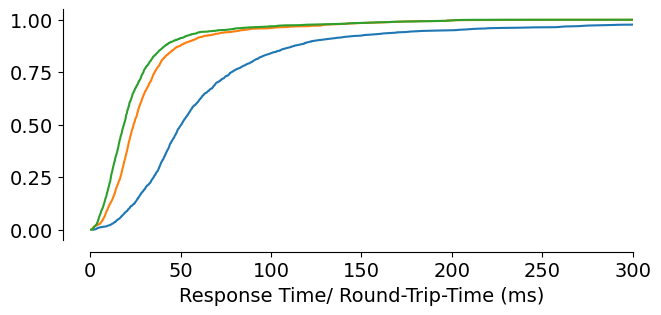

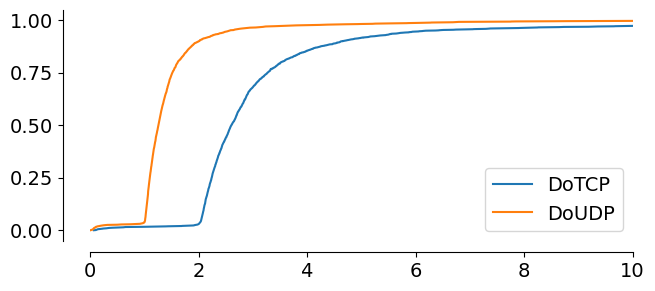

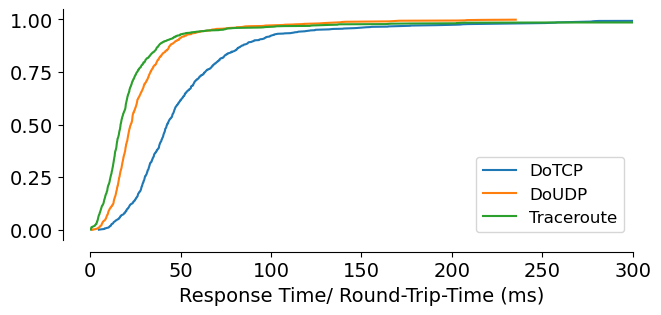

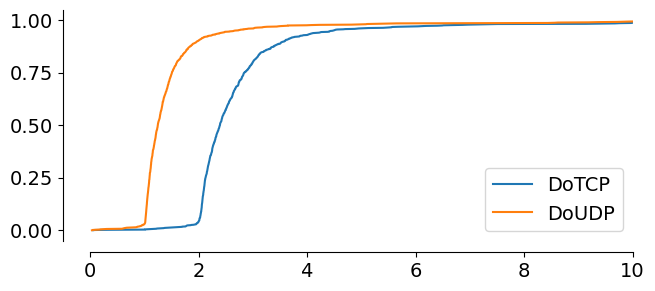

In [186]:
for i in range(len(traceroute_data)): 
    xs = []
    ys = []
    markers = []
    key, df_traceroute = traceroute_data[i]

    i = i*2
    key_tcp, df_tcp = runtime_data_rq1[i]
    key_udp, df_udp = runtime_data_rq1[i + 1]
    
    df_tcp = df_tcp[df_tcp["resolver"] != "Probe Resolver"]
    df_udp = df_udp[df_udp["resolver"] != "Probe Resolver"]

    df_tcp = df_tcp.groupby("prb_id", as_index = False)["rt"].median().dropna()
    df_udp = df_udp.groupby("prb_id", as_index = False)["rt"].median().dropna()
    df_traceroute = df_traceroute.groupby("prb_id", as_index = False)["rtt"].median().dropna()

    df_tcp_tr_merged = df_tcp.merge(df_traceroute, on="prb_id", how="inner")
    df_udp_tr_merged = df_udp.merge(df_traceroute, on="prb_id", how="inner")
   
    df_tcp_tr_merged["rt-to-rtt-ratio"] =  df_tcp_tr_merged["rt"] / df_tcp_tr_merged["rtt"]
    df_udp_tr_merged["rt-to-rtt-ratio"] =  df_udp_tr_merged["rt"] / df_udp_tr_merged["rtt"]
    
    ratio_tcp = df_tcp_tr_merged["rt-to-rtt-ratio"]
    ratio_udp = df_udp_tr_merged["rt-to-rtt-ratio"]
    
    rt_tcp = df_tcp["rt"]
    rt_udp = df_udp["rt"]   
    rtt_traceroute = df_traceroute["rtt"]
    
    fig, ax = plt.subplots()
    fig.set_figwidth(7)
    fig.set_figheight(3)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    for item in [rt_tcp, rt_udp, rtt_traceroute]:
        xs.append(np.sort(item))
        ys.append(np.arange(len(item)) / float(len(item)))
    for item in ["DoTCP", "DoUDP", "Traceroute"]:
        markers.append(f"{item}")
    for i in range(len(xs)): 
        ax.plot(xs[i], ys[i], label=markers[i])
    ax.set_xbound(lower=0, upper=300)
    ax.set_xlabel('Response Time/ Round-Trip-Time (ms)')
    if "IPv6" in key: 
        ax.legend(prop = {"size": 12})    
    savers[0].save_figure(fig, f"traceroute_vs_dns_{key}.pdf")
    
    fig, ax = plt.subplots()
    plt.rcParams['font.size'] = 14
    fig.set_figwidth(7)
    fig.set_figheight(3)

    ax.plot(np.sort(ratio_tcp), np.arange(len(ratio_tcp)) / float(len(ratio_tcp)), label="DoTCP")
    ax.plot(np.sort(ratio_udp), np.arange(len(ratio_udp)) / float(len(ratio_udp)), label="DoUDP")
    ax.set_xbound(lower=0, upper=10)
    ax.legend()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    savers[0].save_figure(fig, f"rt_rtt_ratio_{key}.pdf")
    

    
    
    
    

# Per resolver

In [ ]:
for i in range(len(traceroute_data)): 

    key, df_traceroute = traceroute_data[i]

    i = i*2
    key_tcp, df_tcp = runtime_data_rq1[i]
    key_udp, df_udp = runtime_data_rq1[i + 1]
    
    df_tcp = df_tcp.groupby(["prb_id", "resolver"], as_index = False)["rt"].median().dropna()
    df_udp = df_udp.groupby(["prb_id", "resolver"], as_index = False)["rt"].median().dropna()
    df_traceroute = df_traceroute.groupby(["prb_id", "resolver"], as_index = False)["rtt"].median().dropna()

    df_tcp_tr_merged = df_tcp.merge(df_traceroute, on=["prb_id", "resolver"], how="inner")
    df_udp_tr_merged = df_udp.merge(df_traceroute, on=["prb_id", "resolver"], how="inner")
   
    df_tcp_tr_merged["rt-to-rtt-ratio"] =  df_tcp_tr_merged["rt"] / df_tcp_tr_merged["rtt"]
    df_udp_tr_merged["rt-to-rtt-ratio"] =  df_udp_tr_merged["rt"] / df_udp_tr_merged["rtt"]
    

    fig, ax = plt.subplots()
    fig.set_figwidth(7)
    fig.set_figheight(3)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))

    xs = []
    ys = []
    markers = []
    for resolver, df in df_tcp_tr_merged.groupby("resolver"):   
        if resolver == "Probe Resolver" or resolver == "Comodo":
            continue
        ratio = df["rt-to-rtt-ratio"]
        ax.plot(np.sort(ratio), np.arange(len(ratio)) / float(len(ratio)), label=resolver)
    
    if "IPv4" in key: 
        ratio = df_tcp_tr_merged[df_tcp_tr_merged["resolver"] == "Comodo"]["rt-to-rtt-ratio"]
        ax.plot(np.sort(ratio), np.arange(len(ratio)) / float(len(ratio)), label="Comodo")

    ax.set_xlabel("RT/RTT Ratio", fontsize=14)
    ax.set_xbound(lower=0, upper=15)
    savers[0].save_figure(fig, f"rt_rtt_ratio_per_resolver_dotcp_{key.lower()}.pdf")
    plt.rcParams['font.size'] = 14

    
    fig, ax = plt.subplots()
    fig.set_figwidth(7)
    fig.set_figheight(3)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    xs = []
    ys = []
    markers = []
    for resolver, df in df_udp_tr_merged.groupby("resolver"):        
        if resolver == "Probe Resolver" or resolver == "Comodo":
            continue
        ratio = df["rt-to-rtt-ratio"]
        ax.plot(np.sort(ratio), np.arange(len(ratio)) / float(len(ratio)), label=resolver)
    if "IPv4" in key: 
        ratio = df_udp_tr_merged[df_udp_tr_merged["resolver"] == "Comodo"]["rt-to-rtt-ratio"]
        ax.plot(np.sort(ratio), np.arange(len(ratio)) / float(len(ratio)), label="Comodo")
    else:
        ax.plot([],[], label = "Comodo")
        ax.legend(ncol=2, prop = {"size": 12})    
    ax.set_xlabel("RT/RTT Ratio", fontsize=12)
    ax.set_xbound(lower=0, upper=15)

    savers[0].save_figure(fig, f"rt_rtt_ratio_per_resolver_doudp_{key.lower()}.pdf")


In [ ]:
fig, axs = plt.subplots(ncols = 2)
fig.set_figwidth(16)
fig.set_figheight(7)

plot_count += 0
for i in range(len(traceroute_data)): 
    xs = []
    ys = []
    markers = []
    key, df_traceroute = traceroute_data[i]

    i = i*2
    key_tcp, df_tcp = runtime_data_rq1[i]
    key_udp, df_udp = runtime_data_rq1[i + 1]
    

    df_tcp_prb = df_tcp[df_tcp["resolver"] == "Probe Resolver"].groupby("prb_id", as_index = False)["rt"].median().dropna()
    df_udp_prb = df_udp[df_udp["resolver"] == "Probe Resolver"].groupby("prb_id", as_index = False)["rt"].median().dropna()
    df_tcp_pub = df_tcp[df_tcp["resolver"] != "Probe Resolver"].groupby("prb_id", as_index = False)["rt"].median().dropna()
    df_udp_pub = df_udp[df_udp["resolver"] != "Probe Resolver"].groupby("prb_id", as_index = False)["rt"].median().dropna()

    df_traceroute = df_traceroute.groupby("prb_id", as_index = False)["rtt"].median().dropna()
    
    rt_tcp_prb = df_tcp_prb["rt"]
    rt_udp_prb = df_udp_prb["rt"]   
    rt_tcp_pub = df_tcp_pub["rt"]
    rt_udp_pub = df_udp_pub["rt"]   

    rtt_traceroute = df_traceroute["rtt"]
    
    _, col = get_plot_index(plot_count)
    
    ax = axs[col]
    ax.set_title(key)
    for item in [rt_tcp_prb,rt_tcp_pub, rt_udp_prb, rt_udp_pub, rtt_traceroute]:
        xs.append(np.sort(item))
        ys.append(np.arange(len(item)) / float(len(item)))
    for item in ["DoTCP Probe", "DoTCP Public", "DoUDP Probe", "DoUDP Public", "Traceroute"]:
        markers.append(f"{item}")
    for i in range(len(xs)): 
        ax.plot(xs[i], ys[i], label=markers[i])
    ax.set_xbound(lower=0, upper=300)
    ax.legend()

    plot_count += 1

    
    
    
    